<a href="https://colab.research.google.com/github/AlfredoQuintellaP/sentiment-analysis-performance-study/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [MI201] Sentiment Analysis - Comparative Study

Comparative analysis of different ML approaches for sentiment analysis:
1. Classical ML models
2. BERT embeddings + MLP
3. LLM-based classification

In [4]:
# 1.2 Import all libraries
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# Classical ML models
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)

# ML algorithms
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Neural networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import (BertTokenizer, BertModel,
                         AutoTokenizer, AutoModel,
                         get_linear_schedule_with_warmup)

# Evaluation utilities
from collections import defaultdict, Counter
import time
import json
from datetime import datetime

## Uploading Data

In [6]:
import kagglehub
path = kagglehub.dataset_download('abhi8923shriv/sentiment-analysis-dataset')

print('Data source import complete.')

train_dataset = path + '/train.csv'
test_dataset = path + '/test.csv'

print(os.path.exists(train_dataset))
print(os.path.exists(test_dataset))

Using Colab cache for faster access to the 'sentiment-analysis-dataset' dataset.
Data source import complete.
True
True


## Info of the Dataframes

Fast look of the formats, types and quantity in the dataframes

In [9]:
train_df = pd.read_csv(train_dataset, encoding='ISO-8859-1')
test_df = pd.read_csv(test_dataset, encoding='ISO-8859-1')

print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

print(f"Training info: {train_df.info()}")

print("\nFirst few rows of the training dataset:")
print(train_df.head())

print("\nFirst few rows of the test dataset:")
print(test_df.head())

Train dataset shape: (27481, 10)
Test dataset shape: (4815, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB
Training info: None

First few rows of the training dataset:
       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  54

Handling null values

In [13]:
train_df.isnull().sum()
train_df = train_df.dropna()
train_df.isnull().sum()

test_df.isnull().sum()
test_df = test_df.dropna()
test_df.isnull().sum()

,0
textID,0
text,0
sentiment,0
Time of Tweet,0
Age of User,0
Country,0
Population -2020,0
Land Area (Km²),0
Density (P/Km²),0


## Removing stopwords & lowercasing all text

Basically, the stopwords are words too common and that don't have that much of a semantic value. Some examples are: the, is, at, on, and.


In [14]:
# Download necessary NLTK data
nltk.download('stopwords')

# Text preprocessing function that removes stopwords and convert text to lowercase

def preprocess_text(text):
    text = text.lower()

    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])

    return text

train_df['processed_text'] = train_df['text'].apply(preprocess_text)
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploratory Data Analysis


Sentiment distribution


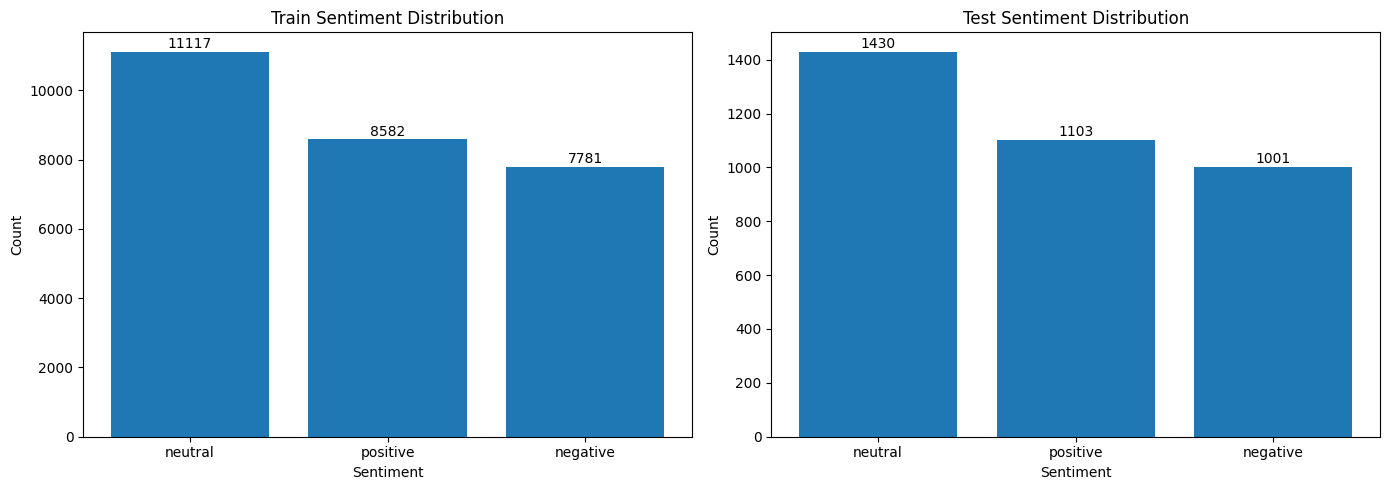

In [25]:
print("\n" + "="*60)
print("Sentiment distribution")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14,5))

train_counts = train_df['sentiment'].value_counts()
axes[0].bar(train_counts.index, train_counts.values)
axes[0].set_title('Train Sentiment Distribution')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')
for i, v in enumerate(train_counts.values):
    axes[0].text(i, v + max(train_counts.values)*0.01, str(v), ha='center')

test_counts = test_df['sentiment'].value_counts()
axes[1].bar(test_counts.index, test_counts.values)
axes[1].set_title('Test Sentiment Distribution')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Count')
for i, v in enumerate(test_counts.values):
    axes[1].text(i, v + max(test_counts.values)*0.01, str(v), ha='center')

plt.tight_layout()
plt.show()


Text Length analysis


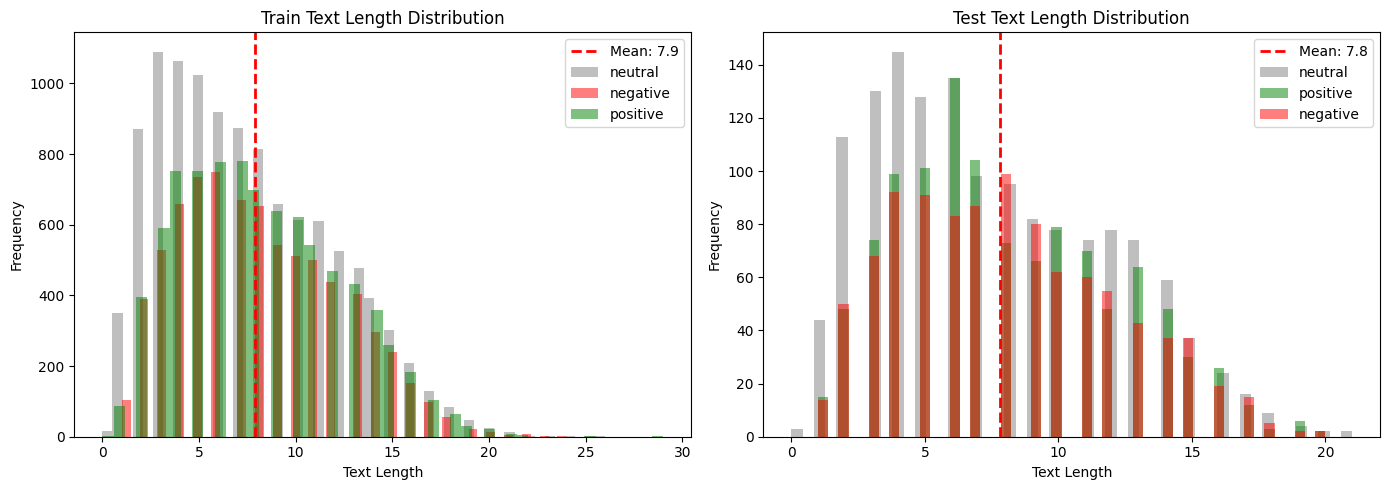

In [30]:
print("\n" + "="*60)
print("Text Length analysis")
print("="*60)

train_df['text_length'] = train_df['processed_text'].apply(lambda x: len(x.split()))
test_df['text_length'] = test_df['processed_text'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(14,5))
sentiment_colors = {'negative': 'red', 'neutral': 'gray', 'positive': 'green'}


axes[0].axvline(train_df['text_length'].mean(), color='red', linestyle='dashed',
                linewidth=2, label=f'Mean: {train_df["text_length"].mean():.1f}')
axes[0].set_title('Train Text Length Distribution')
axes[0].set_xlabel('Text Length')
axes[0].set_ylabel('Frequency')
for sentiment in train_df['sentiment'].unique():
    sentiment_data = train_df[train_df['sentiment'] == sentiment]
    axes[0].hist(sentiment_data['text_length'], bins=50, color=sentiment_colors[sentiment],
                 alpha=0.5, label=sentiment)
axes[0].legend()

axes[1].axvline(test_df['text_length'].mean(), color='red', linestyle='dashed',
                linewidth=2, label=f'Mean: {test_df["text_length"].mean():.1f}')
axes[1].set_title('Test Text Length Distribution')
axes[1].set_xlabel('Text Length')
axes[1].set_ylabel('Frequency')
for sentiment in test_df['sentiment'].unique():
    sentiment_data = test_df[test_df['sentiment'] == sentiment]
    axes[1].hist(sentiment_data['text_length'], bins=50, color=sentiment_colors[sentiment],
                 alpha=0.5, label=sentiment)
axes[1].legend()

plt.tight_layout()
plt.show()


Word clouds


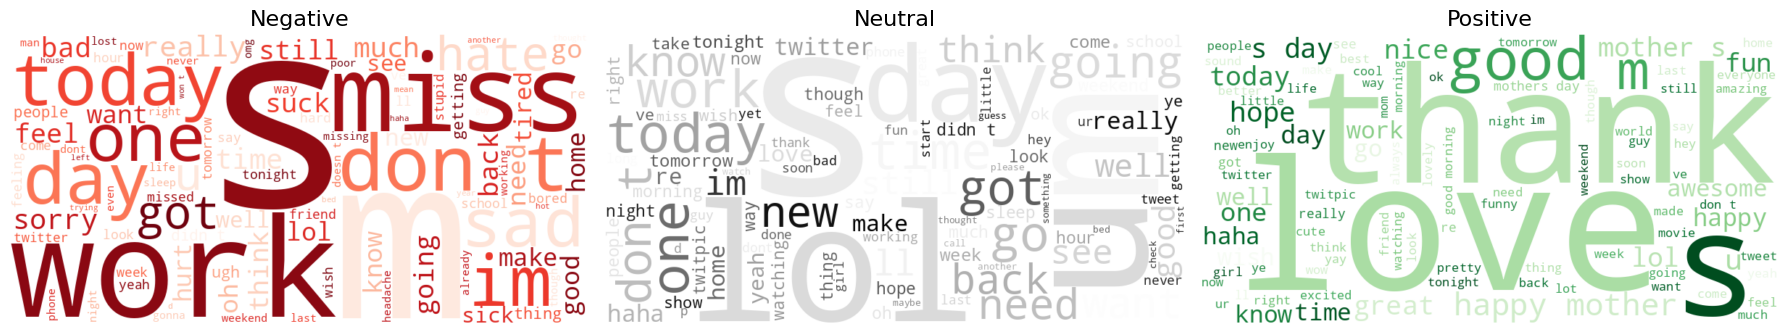

In [28]:
print("\n" + "="*60)
print("Word clouds")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(18,6))

sentiments = ['negative', 'neutral', 'positive']
titles = ['Negative', 'Neutral', 'Positive']
colors = ['Reds', 'Grays', 'Greens']

for idx, (sentiment, title, color) in enumerate(zip(sentiments, titles, colors)):
    text = " ".join(train_df[train_df['sentiment'] == sentiment]['processed_text'])
    if text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color='white',
                              colormap=color, max_words=100).generate(text)
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(title, fontsize=16)
    else:
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

# letter s possible doing nothing, check later why so common in every set and what it changes


Analysing most frequent words


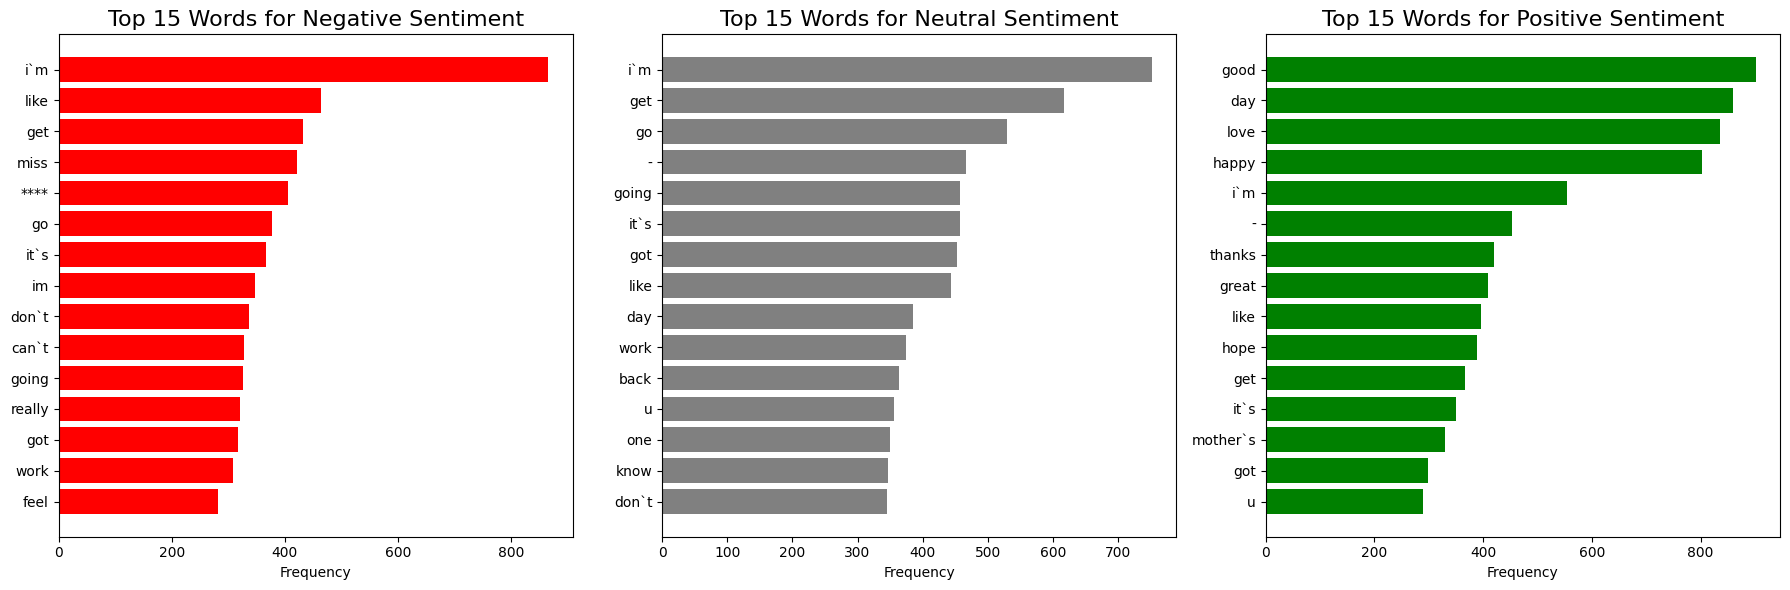

In [34]:
print("\n" + "="*60)
print("Analysing most frequent words")
print("="*60)

def get_top_words(text_series, n=20):
    all_words = ' '.join(text_series).split()
    word_freq = Counter(all_words)
    return word_freq.most_common(n)

fig, axes = plt.subplots(1, 3, figsize=(18,6))

for idx, sentiment in enumerate(sentiments):
    sentiment_text = train_df[train_df['sentiment'] == sentiment]['processed_text']
    top_words = get_top_words(sentiment_text, 15)

    words, counts = zip(*top_words) if top_words else ([], [])

    if words:
        axes[idx].barh(range(len(words)), counts, color=sentiment_colors[sentiment])
        axes[idx].set_yticks(range(len(words)))
        axes[idx].set_yticklabels(words)
        axes[idx].invert_yaxis()
        axes[idx].set_title(f'Top 15 Words for {sentiment.capitalize()} Sentiment', fontsize=16)
        axes[idx].set_xlabel('Frequency')
    else:
        axes[idx].text(0.5, 0.5, 'No words found',
                       ha = 'center', va='center')
        axes[idx].set_title(f'Top 15 Words for {sentiment.capitalize()} Sentiment', fontsize=16)


plt.tight_layout()
plt.show()

# maybe test taking some words out, there are some that looks like noise, but maybe im just dumb

# Data Preparation for Modeling

In [39]:
print("\n" + "="*60)
print("Encoding sentiment labels")
print("="*60)

label_encoder = LabelEncoder()
train_df['encoded_sentiment'] = label_encoder.fit_transform(train_df['sentiment'])
test_df['encoded_sentiment'] = label_encoder.transform(test_df['sentiment'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Label mapping: {label_mapping}")

print("\n" + "="*60)
print("Preparing data splitss")
print("="*60)

X_train_classical = train_df['processed_text']
y_train_classical = train_df['encoded_sentiment']
X_test_classical = test_df['processed_text']
y_test_classical = test_df['encoded_sentiment']

# For validation splis (for neural networks)
X_temp, X_val, y_temp, y_val = train_test_split(X_train_classical, y_train_classical,
                                                    test_size=0.2, random_state=42)

print(f"Training set size: {len(X_temp)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test_classical)}")

print("\n" + "="*60)
print("Organizing vectorization options")
print("="*60)
# prints the same values over and over (hopefully), so we can check if any vectorization
# made a mstk

print("TF-IDF Vectorization:")

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,              #
    ngram_range=(1, 2),             # using unigrams and bigrams
    stop_words='english',
    min_df=5,                       # ignoring terms with freq less than 5
    max_df=0.7,                     # ignoring terms with freq bigger than 70%
    sublinear_tf=True               # using sublinear scaling
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_temp)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test_classical)
print(f"TF-IDF Train set shape: {X_train_tfidf.shape}")
print(f"TF-IDF Validation set shape: {X_val_tfidf.shape}")
print(f"TF-IDF Test set shape: {X_test_tfidf.shape}")

print("\n" + "="*60)
print("\nCount vectorization (Bag of Words):")

count_vectorizer = CountVectorizer(
    max_features=5000,              #
    ngram_range=(1, 2),             # using unigrams and bigrams
    stop_words='english',
    min_df=5,                       # ignoring terms with freq less than 5
    max_df=0.7                      # ignoring terms with freq bigger than 70%
)

X_train_count = count_vectorizer.fit_transform(X_temp)
X_val_count = count_vectorizer.transform(X_val)
X_test_count = count_vectorizer.transform(X_test_classical)
print(f"Count Train set shape: {X_train_count.shape}")
print(f"Count Validation set shape: {X_val_count.shape}")
print(f"Count Test set shape: {X_test_count.shape}")

print("\n" + "="*60)
print("\nBERT tokenizer:")

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print(f"BERT tokenizer: {bert_tokenizer}")


Encoding sentiment labels
Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}

Preparing data splitss
Training set size: 21984
Validation set size: 5496
Test set size: 3534

Organizing vectorization options
TF-IDF Vectorization:
TF-IDF Train set shape: (21984, 4643)
TF-IDF Validation set shape: (5496, 4643)
TF-IDF Test set shape: (3534, 4643)


Count vectorization (Bag of Words):
Count Train set shape: (21984, 4643)
Count Validation set shape: (5496, 4643)
Count Test set shape: (3534, 4643)


## Now we can start answering the questions

First, lets remember all the questions:

- Question 0: please analyse the dataset with differents classical machine learning model
- Question 1: please perform a classification with differents classical machine learning model and analyse the performences
- Question 2: please perform a classification with a MLP?
- Question 3: please analyse all the performences and explain which is the best
- Question 4: please use an LLM compare your performences to a LLM
- Quesiton 5: please explain why I choose a BERT embedding instead of the raw text
- Question 6: please read the BERT paper and explain the BERT architecture
- Question 7: please finetue with LORA an LLM to classify the sentiment (optional)

To organize everything, the sections we re going to make are:

### Section 1: Classical ML Models:
1. Naive Bayes Classifier
2. Logistic Regression
3. SVM classifier
4. Random Forest
5. XGBoost
6. Model Comparision Table and Theoric Conclusion
### Section 2: Neural Network aproaches:
1. MLP Classifier
2. BERT Embeddings + Classifier
3. BERT Fine-tuning
4. Perfomance Comparisions and Theoric Conclusion
### Section 3: LLM-Based Classification
1. Zero-shot Classification with GPT/LLaMA
2. Few-shot/Prompt Engineering
3. LoRA Fine-tuning
4. Comparison with previous models
### Section 4: Comprehensive Analysis & Conclusions
1. All Models Perfomance Comparison Table
2. Error Analysis (confusions matrices, misclassified samples)
3. Computational Cost Analysis (training/inference time)
4. Why BERT embedding?
5. BERT Architecture Explaination
### Section 5: Answers Summary & References
1. Summary Table with All Question Answers
2. General conclusion and bibliography